In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from cpsplines.fittings.grid_cpsplines import GridCPsplines
from cpsplines.graphics.plot_one_smoothing import plot_curves
from cpsplines.psplines.bspline_basis import BsplineBasis
from cpsplines.psplines.penalty_matrix import PenaltyMatrix

from multiple_curves import MultipleCurves

from aux_func import (zoom_covid,
                      plot_bspline_basis,
                      get_simulated_errors,
                      simulated_incr_function,
                      simulated_multiple_function,
                      simulated_nonneg_function,
                      plot_confidence_bands,
                      report_Lp_distances,
                      predict_covid)  

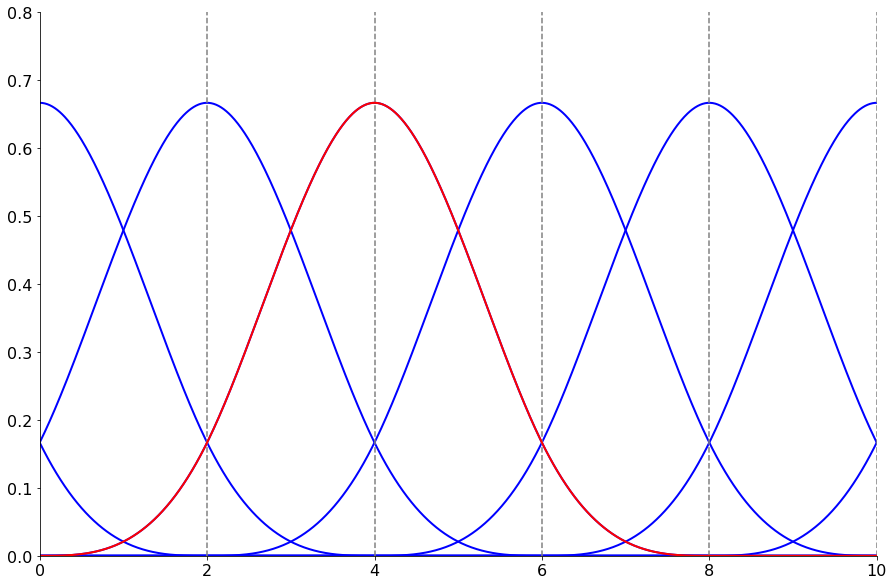

In [3]:
# Generate a B-spline basis 
bsp = BsplineBasis(deg=3, xsample=np.linspace(0,10,1001), n_int=5)
_ = bsp.get_matrix_B()

# Plot the B-splines basis, colouring one element of the basis in red
fig, ax = plot_bspline_basis(bsp=bsp, figsize=(15,10), plot_knots=True, bsp_depict=(3,))
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = ax.set_xlim(0, 10)
_ = ax.set_ylim(0, 0.8)
_ = fig.savefig("../img/Bsplines.pdf", bbox_inches="tight")

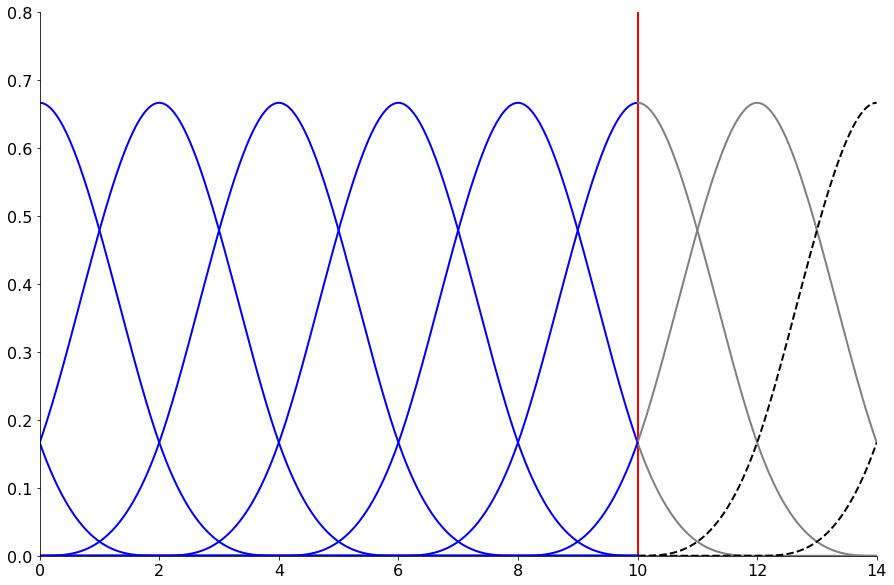

In [4]:
# Generate a B-spline basis with forecasting region  
bsp = BsplineBasis(deg=3, xsample=np.linspace(0,10,1001), n_int=5, prediction={"forward": 14})
_ = bsp.get_matrix_B()

# Plot the B-spline basis and part of the forecasting region
fig, ax = plot_bspline_basis(bsp=bsp, figsize=(15,10))
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = ax.set_ylim(0, 0.8)
_ = ax.set_xlim(0, 14)
_ = fig.savefig("../img/Bsplines_extended.pdf", bbox_inches="tight")

In [5]:
params = {"deg": (3,),
          "ord_d": (2,),
          "n_int": (40,),
          "sp_method": "optimizer",
          "sp_args": {"options": {"ftol": 1e-6}}}

dict_df = {}
if not os.path.exists("../data/errors_monotone.csv"):
    for sigma in (0.15, 0.3):
        sin_df, con_df = get_simulated_errors(func=simulated_incr_function,
                                              n_iter=100,
                                              sigma=sigma,
                                              size=100,
                                              first_seed=0,
                                              constraints={0: {1: {"+": 0}}},
                                              **params)
        dict_df[str(sigma)] = pd.concat({"unconstrained": sin_df, "monotone": con_df})

    _ = pd.concat(dict_df).to_csv("../data/errors_monotone.csv")
    
df_monotone = pd.read_csv("../data/errors_monotone.csv", index_col=[0,1,2])
cols_monotone = ["100*mu_2", "100*std_2", "mu_inf", "std_inf", "10*mu_1", "10*std_1"]

In [6]:
errors_15_u = report_Lp_distances(df_monotone.loc[0.15, :].loc["unconstrained"],
                                  ps=[2, np.inf, 1],
                                  factors=[100, 1, 10],
                                  ponder=True,
                                  round_n=3)
errors_15_m = report_Lp_distances(df_monotone.loc[0.15, :].loc["monotone"],
                                  ps=[2, np.inf, 1],
                                  factors=[100, 1, 10],
                                  ponder=True,
                                  round_n=3)
errors_15 = {"Papp w/o penalty unconstrained": pd.Series([1.634, 1.014, 0.459, 0.230, 0.880, 0.148]),
             "Papp with penalty unconstrained": pd.Series([1.678, 0.825, 0.455, 0.159, 0.904, 0.166]),
             "Problem (9)": errors_15_u,
             "Papp w/o penalty monotone": pd.Series([1.344, 0.412, 0.481, 0.114, 0.749, 0.118]),
             "Papp with penalty monotone": pd.Series([0.807, 0.477, 0.339, 0.127, 0.610, 0.113]),
             "Problem (13)": errors_15_m}
pd.concat(errors_15).unstack().rename(columns={i: col for i, col in enumerate(cols_monotone)})

,100*mu_2,100*std_2,mu_inf,std_inf,10*mu_1,10*std_1
Papp w/o penalty unconstrained,1.634,1.014,0.459,0.230,0.880,0.148
Papp with penalty unconstrained,1.678,0.825,0.455,0.159,0.904,0.166
Problem (9),0.800,0.096,0.256,0.058,0.619,0.084
Papp w/o penalty monotone,1.344,0.412,0.481,0.114,0.749,0.118
Papp with penalty monotone,0.807,0.477,0.339,0.127,0.610,0.113
Problem (13),0.704,0.092,0.251,0.062,0.522,0.082


In [7]:
errors_30_u = report_Lp_distances(df_monotone.loc[0.3, :].loc["unconstrained"],
                                  ps=[2, np.inf, 1],
                                  factors=[100, 1, 10],
                                  ponder=True,
                                  round_n=3)
errors_30_m = report_Lp_distances(df_monotone.loc[0.3, :].loc["monotone"],
                                  ps=[2, np.inf, 1],
                                  factors=[100, 1, 10],
                                  ponder=True,
                                  round_n=3)
errors_30 = {"Papp w/o penalty unconstrained": pd.Series([4.619, 7.798, 0.659, 0.513, 1.475, 0.237]),
             "Papp with penalty unconstrained": pd.Series([5.359, 7.279, 0.737, 0.536, 1.581, 0.388]),
             "Problem (9)": errors_30_u,
             "Papp w/o penalty monotone": pd.Series([4.426, 0.911, 0.715, 0.110, 1.478, 0.177]),
             "Papp with penalty monotone": pd.Series([4.052, 7.799, 0.581, 0.307, 1.290, 0.679]),
             "Problem (13)": errors_30_m}
pd.concat(errors_30).unstack().rename(columns={i: col for i, col in enumerate(cols_monotone)})

,100*mu_2,100*std_2,mu_inf,std_inf,10*mu_1,10*std_1
Papp w/o penalty unconstrained,4.619,7.798,0.659,0.513,1.475,0.237
Papp with penalty unconstrained,5.359,7.279,0.737,0.536,1.581,0.388
Problem (9),1.403,0.178,0.429,0.104,1.094,0.157
Papp w/o penalty monotone,4.426,0.911,0.715,0.110,1.478,0.177
Papp with penalty monotone,4.052,7.799,0.581,0.307,1.290,0.679
Problem (13),1.265,0.191,0.405,0.108,0.969,0.170


In [8]:
# Simulate the data 
np.random.seed(0)
x = np.sort(np.random.uniform(low=0.0, high=1.0, size=100))
y_teo = simulated_incr_function(x)
y_15 = y_teo + np.random.normal(0, 0.15, 100)
y_30 = y_teo + np.random.normal(0, 0.3, 100)

# Generate thinner covariate sample so the plot looks smoother (not used to fit
# the data, only to predict new values with the fitted coefficients)
x_ext = np.linspace(np.min(x),np.max(x),1001)
y_ext = simulated_incr_function(x_ext)

params = {"deg": (3,),
          "ord_d": (2,),
          "n_int": (40,),
          "sp_method": "optimizer",
          "sp_args": {"options": {"ftol": 1e-6}}}

dict_y = {}
for y, sigma in zip((y_15, y_30), ("0.15", "0.3")):
    dict_sigma = {}
    # Get the unconstrained curve 
    sin = GridCPsplines(**params)
    _ = sin.fit(x=(x,), y=y)
    dict_sigma["unconstrained"] = sin.predict(x=(x_ext,))

    # Get the non-decreasing curve
    con = GridCPsplines(**params, int_constraints={0: {1: {"+": 0.0}}})
    _ = con.fit(x=(x,), y=y)
    dict_sigma["monotone"] = con.predict(x=(x_ext,))
    dict_y[sigma] = dict_sigma
                                

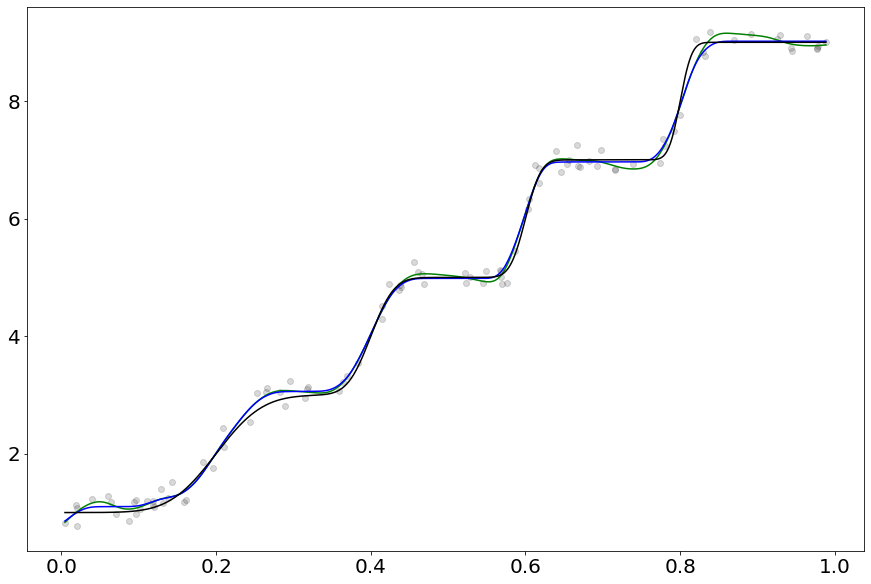

In [9]:
#Plot a sample plot for standard deviation 0.15, together with the theoretical curve
fig, ax = plt.subplots(figsize = (15, 10))
_ = ax.scatter(x, y_15, c="k", alpha=0.15)
_ = ax.plot(x_ext, dict_y["0.15"]["unconstrained"], c="g", label="Unconstrained curve")
_ = ax.plot(x_ext, dict_y["0.15"]["monotone"], c="b", label="Monotonicity in $[x_1, x_n]$")
_ = ax.plot(x_ext, y_ext, c="k", label="Theoretical curve")
_ = ax.tick_params(axis='both', which='major', labelsize=20)
_ = fig.savefig("../img/monotone_15.pdf", bbox_inches="tight")

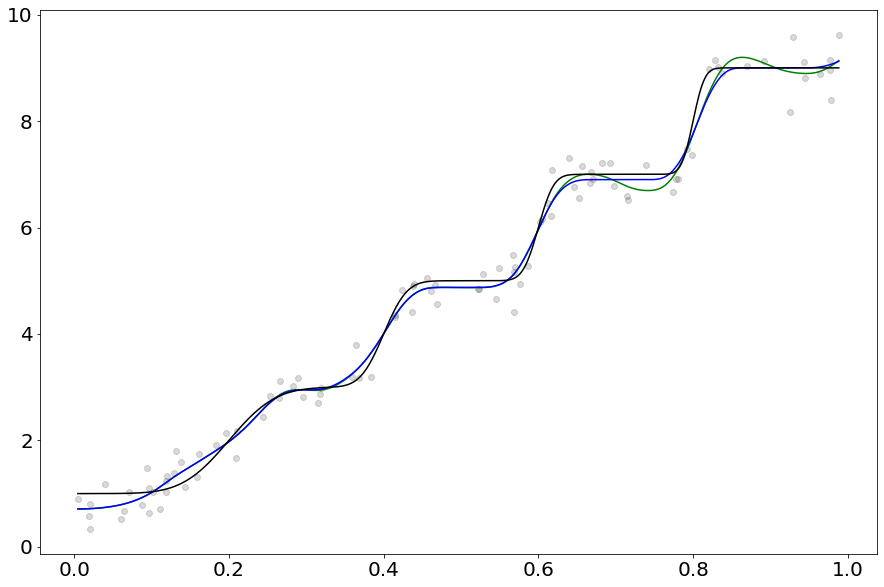

In [10]:
#Plot a sample plot for standard deviation 0.30, together with the theoretical curve
fig, ax = plt.subplots(figsize = (15, 10))
_ = ax.scatter(x, y_30, c="k", alpha=0.15)
_ = ax.plot(x_ext, dict_y["0.3"]["unconstrained"], c="g", label="Unconstrained curve")
_ = ax.plot(x_ext, dict_y["0.3"]["monotone"], c="b", label="Monotonicity in $[x_1, x_n]$")
_ = ax.plot(x_ext, y_ext, c="k", label="Theoretical curve")
_ = ax.tick_params(axis='both', which='major', labelsize=20)
_ = fig.savefig("../img/monotone_30.pdf", bbox_inches="tight")

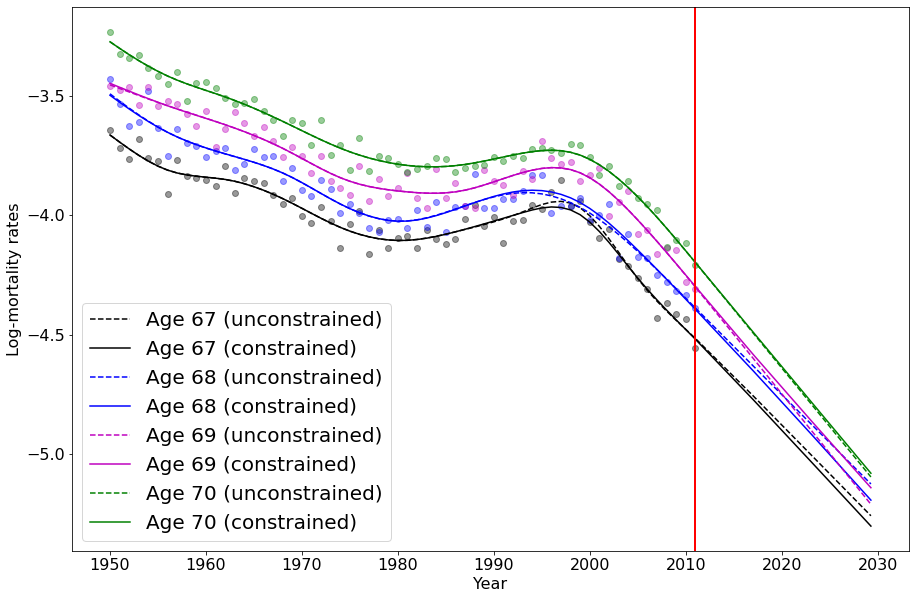

In [11]:
# Load the mortality data 
df = pd.read_csv("../data/data_mortality_67_70.csv")
x = df.query("Age == 67")["Year"].values
# `y` is a matrix with 4 rows, one by age
y = df["y"].values.reshape(
    (df["Age"].nunique(), int(df.shape[0] / df["Age"].nunique()))
)

params_one = {"deg": (3, ),
              "ord_d": (2, ),
              "n_int": (10, ),
              "x_range": {0: (2025, )},
              "sp_method": "optimizer",
              "sp_args": {"options": {"ftol": 1e-9}}}

# The unconstrained problem is separable, so we find the best smoothing
# parameters by separate
cps_sin = GridCPsplines(**params_one)
best_params = []
for i in range(df["Age"].nunique()):
    cps_sin.fit(x=(x, ), y=y[i, :])
    best_params.append(cps_sin.best_sp)

params_multi = {"deg": 3,
                "ord_d": 2,
                "n_int": 10,
                "x_range": (2025, ),
                "sp_grid": best_params}

# Fit the unconstrained model 
cps_sin = MultipleCurves(**params_multi)
cps_sin.fit(x=x, y=y)

# Fit the constrained model (curves cannot cross over, with 0.05 threshold) 
cps_con = MultipleCurves(**params_multi, overlap_thr=(0.05, 0.05, 0.05))
cps_con.fit(x=x, y=y)

# Plot the data
colors = ["k", "b", "m", "g"]
ages = [67, 68, 69, 70]
fig, ax = plt.subplots(figsize=(15, 10))
# Get the knots located at the forward prediction region and concatenate them
# with the observed points
ext_x = np.concatenate((x, cps_sin.bspline_basis.knots[cps_sin.n_int + cps_sin.deg + 1 : -cps_sin.deg]))
for i, (col, ag) in enumerate(zip(colors, ages)):
    _ = ax.scatter(x, y[i, :], c=col, alpha=0.4)
    _ = ax.plot(ext_x, cps_sin.y_fitted[i, :], c=col, label=f"Age {ag} (unconstrained)", linestyle="--")
    _ = ax.plot(ext_x, cps_con.y_fitted[i, :], c=col, label=f"Age {ag} (constrained)")
    _ = ax.axvline(x.max(), c="r")
_ = ax.set_xlabel("Year", fontsize=16)
_ = ax.set_ylabel("Log-mortality rates", fontsize=16)
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = ax.legend(prop={"size": 20})

_ = fig.savefig("../img/mortality.pdf", bbox_inches="tight")

In [12]:
# Load the data
data_aragon = pd.read_csv("../data/covid_aragon_1D.csv")
dates = pd.to_datetime(data_aragon["fecha"]).dt.date
x = data_aragon.index.values
y = data_aragon["num_casos"].values[: len(x)]
y_norm = (y - np.min(y)) / np.ptp(y)

params = {"deg": (3,),
          "ord_d": (2,),
          "n_int": (30,),
          "sp_method": "optimizer",
          "sp_args": {"options": {"ftol": 1e-6}}
          }

# Fit the data with the unconstrained model  
covid_unconstrained = GridCPsplines(**params)
covid_unconstrained.fit(x=(x,), y=y_norm)
covid_unconstrained.y_fitted = np.ptp(y)*covid_unconstrained.y_fitted + np.min(y)

# Fit the data with the non-negativity constrained model  
covid_nonneg = GridCPsplines(**params, int_constraints={0: {0: {"+": 0}}})
covid_nonneg.fit(x=(x,), y=y_norm)
covid_nonneg.y_fitted = np.ptp(y)*covid_nonneg.y_fitted + np.min(y)

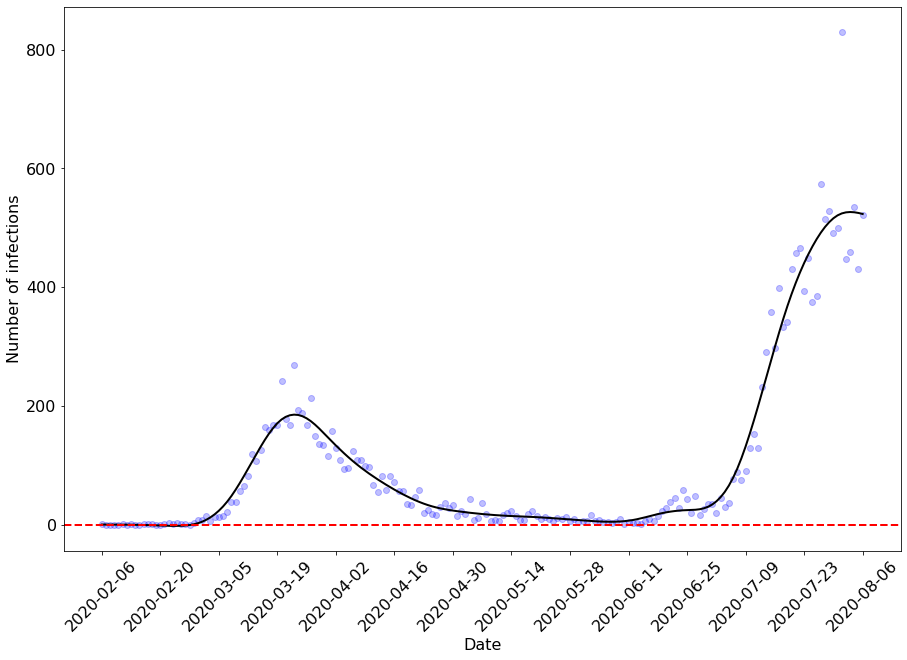

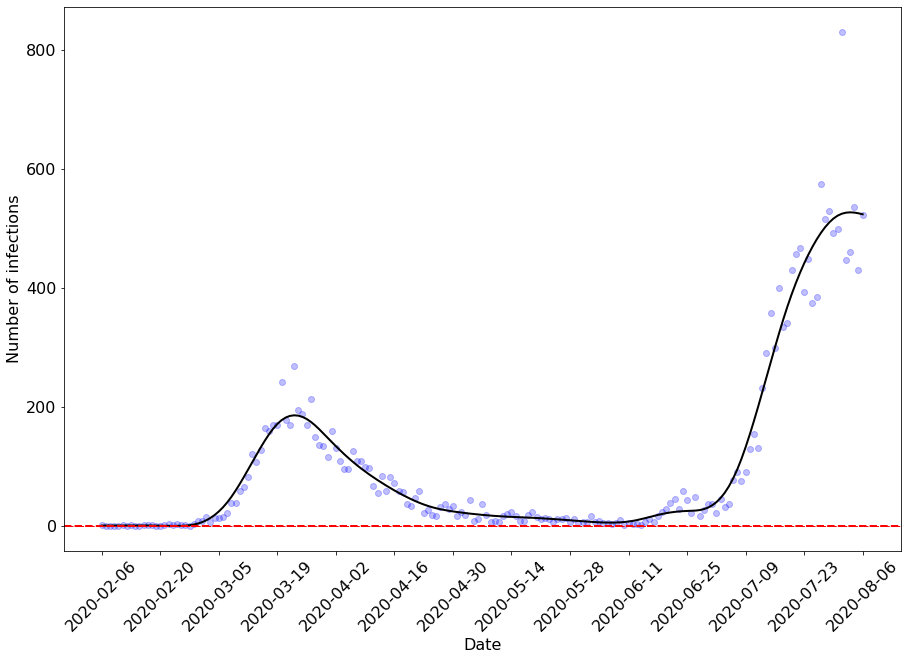

In [13]:
# Plot the unconstrained and the non-negative curve together with the observed points 
paths = ["../img/COVID_negativa.pdf", "../img/COVID_negativa_fixed.pdf"]
for path, model in zip(paths, (covid_unconstrained, covid_nonneg)):
    fig, ax = plot_curves(fittings=(model, ),
                          col_curve="k",
                          x=(x, ),
                          y=(y, ),
                          col_pt=("b",),
                          alpha=0.25,
                          knot_positions=False,
                          constant_constraints=True,
                          figsize=(15,10))


    _ = ax.set_xticks(ticks=x[::14])
    _ = ax.set_xticklabels(labels=dates[: len(x) : 14].values, rotation=45)
    _ = ax.set_xlabel(xlabel="Date", fontsize=16)
    _ = ax.set_ylabel(ylabel="Number of infections",fontsize=16)
    _ = ax.axhline(y=0, color="red", linewidth=2.0, linestyle="--")
    _ = ax.tick_params(axis='both', which='major', labelsize=16)
    _ = fig.savefig(path, bbox_inches="tight")

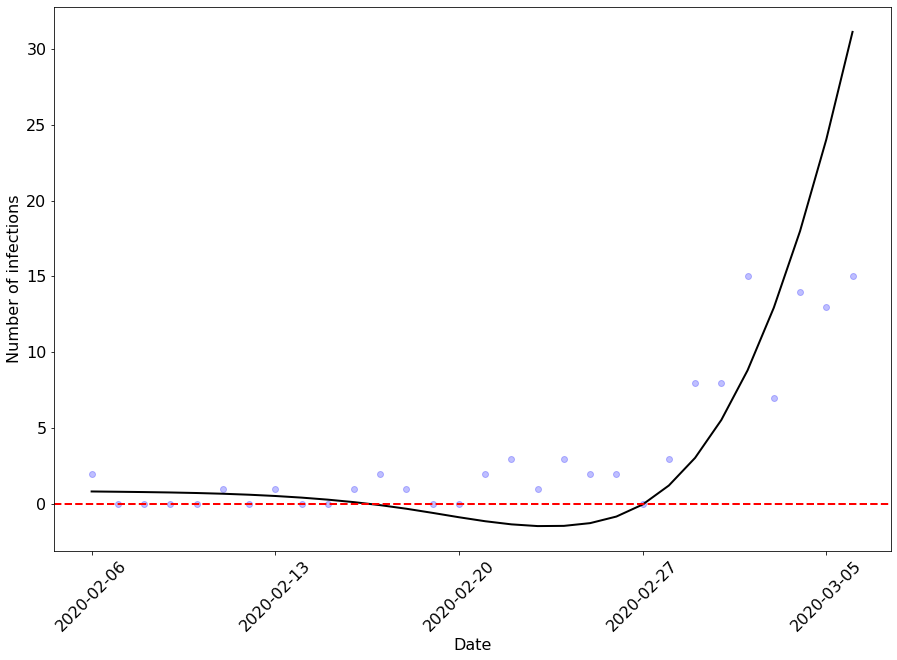

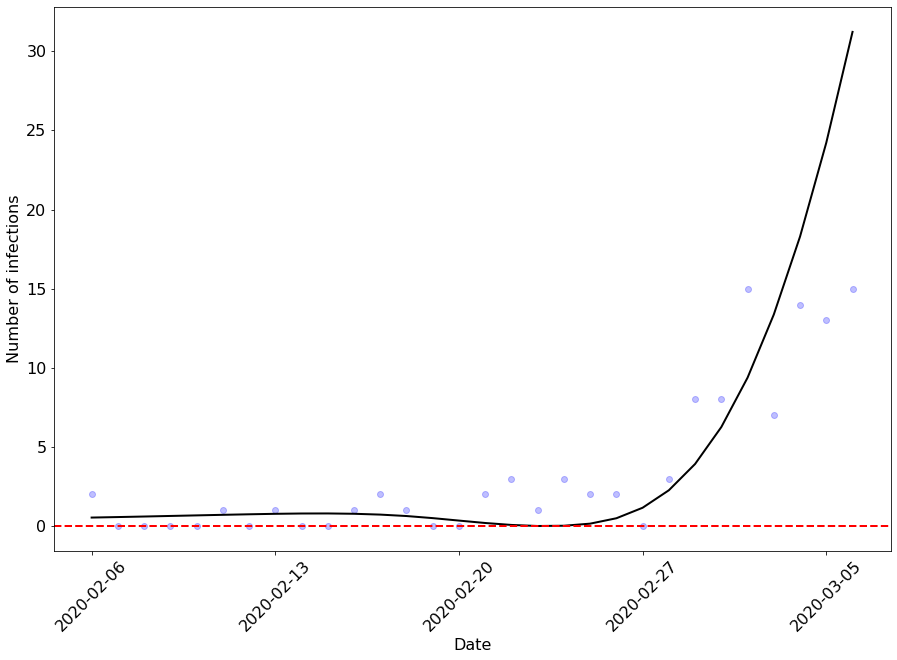

In [14]:
# Zoom part of the previous figures
paths = ["../img/COVID_negativa_ampliada.pdf", "../img/COVID_negativa_ampliada_fixed.pdf"]
for path, model in zip(paths, (covid_unconstrained, covid_nonneg)):
    fig, ax = zoom_covid(x=x,
                         y=y,
                         y_curve=model.y_fitted,
                         zoom_pts=(0,30),
                         alpha=0.25,
                         y_hline=0,
                         figsize=(15,10))
    _ = ax.set_xticks(ticks=x[:30:7])
    _ = ax.set_xticklabels(labels=dates[:30:7].values, rotation=45)
    _ = ax.set_xlabel(xlabel="Date", fontsize=16)
    _ = ax.set_ylabel(ylabel="Number of infections", fontsize=16)
    _ = ax.tick_params(axis='both', which='major', labelsize=16)
    _ = fig.savefig(path, bbox_inches="tight")

In [15]:
# Fix the 15th July as the last day with observations
x_max = 161
# And set the prediction horizon on the 29th July
x_pred = x_max + 14
x = x[:x_pred]
y = y[: len(x)]
x_fore = np.arange(x[x_max - 1] + 1, x_pred + 1, 1)
params = {"deg": (3,),
          "ord_d": (2,),
          "n_int":(27,),
          "x_range": {0: (x_pred, )},
          "int_constraints": {0: {0: {"+": 0}}}}

factors_dict = {"lag": (1, 2, 1.5), "factor_deriv": (1, 3, 2)}
d = predict_covid(x=x[:x_max],
                  y=y[:x_max],
                  factors_dict=factors_dict,
                  x_pred=x_pred,
                  deriv_range=slice(37,52),
                  tol=0.001,
                  **params)

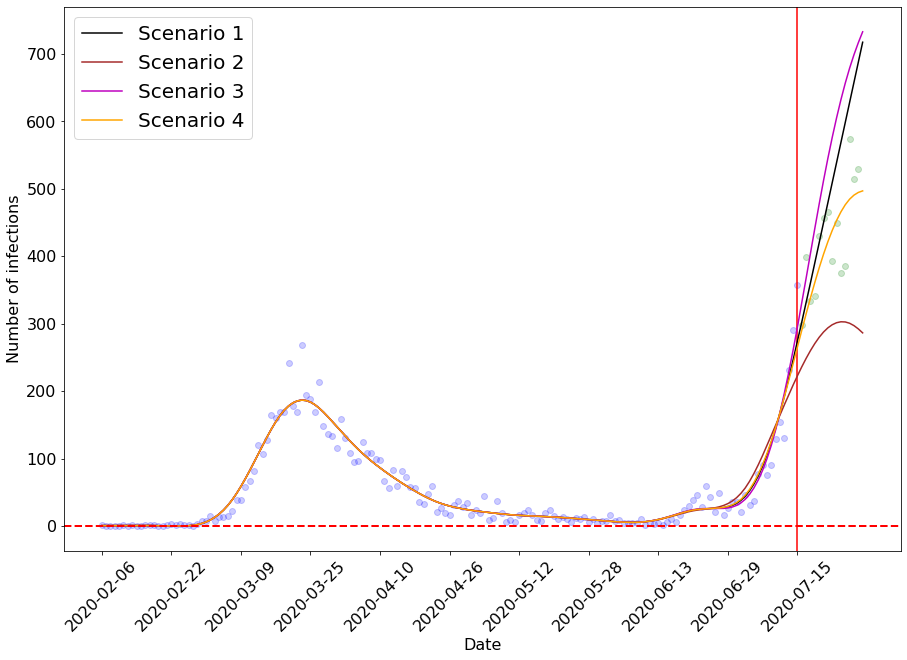

In [16]:
# Plot the unconstrained curve together with the observed points 
colors = ["k", "brown", "m", "orange"]
fig, ax = plt.subplots(figsize=(15,10))
_ = ax.scatter(x[:x_max], y[:x_max], c="b", alpha=0.2)
_ = ax.scatter(x[x_max:x_pred], y[x_max:x_pred], c="g", alpha=0.2)
# Red line on the beginning of the forecasting region
_ = ax.axvline(x[x_max - 1], c="r")
# Plot every constrained curve
for i, y_c in enumerate(d.values()):
    _ = ax.plot(np.concatenate((x[:x_max], x_fore)), y_c, c=colors[i], label=f"Scenario {i+1}")
_ = ax.set_xticks(ticks=x[::16])
_ = ax.set_xticklabels(labels=dates[: len(x) : 16].values, rotation=45)
_ = ax.set_xlabel(xlabel="Date", fontsize=16)
_ = ax.set_ylabel(ylabel="Number of infections", fontsize=16)
_ = ax.axhline(y=0, color="red", linewidth=2.0, linestyle="--")
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = ax.legend(prop={"size": 20})
_ = fig.savefig("../img/COVID_models.pdf", bbox_inches="tight")

In [17]:
params3 = {"deg": (3,),
           "ord_d": (2,),
           "n_int": (40,),
           "sp_method": "optimizer",
           "sp_args": {"options": {"ftol": 1e-6}}}

params4 = {"deg": (4,),
           "ord_d": (2,),
           "n_int": (40,),
           "sp_method": "optimizer",
           "sp_args": {"options": {"ftol": 1e-6}}}

constraints = ({0: {0: {"+": 0}}},
               {0: {0: {"+": 0}, 1: {"+": 0}}},
               {0: {0: {"+": 0}, 2: {"-": 0}}},
               {0: {0: {"+": 0}, 1: {"+": 0}, 2: {"-": 0}}})
names = ["nonneg", "nonneg_incr", "nonneg_conc", "nonneg_incr_conc3"]

dict_df = {}
if not os.path.exists("../data/errors_multiple.csv"):
    for name, c in zip(names, constraints):
        sin_df_20, con_df_20 = get_simulated_errors(func=simulated_multiple_function,
                                                    n_iter=100,
                                                    sigma=0.2,
                                                    size=50,
                                                    first_seed=0,
                                                    constraints=c,
                                                    **params3)
        dict_df[name] = con_df_20
    
    sin_df_20, con_df_20 = get_simulated_errors(func=simulated_multiple_function,
                                                n_iter=100,
                                                sigma=0.2,
                                                size=50,
                                                first_seed=0,
                                                constraints=c,
                                                **params4)
    dict_df["nonneg_incr_conc4"] = con_df_20
    pd.concat(dict_df).to_csv("../data/errors_multiple.csv")
df_multiple = pd.read_csv("../data/errors_multiple.csv", index_col=[0,1])

In [18]:
cols_multiple = ["1000*mu_2", "1000*std_2", "1000*mu_1", "1000*std_1", "mu_inf", "std_inf"]
errors_multiple = {}
for name in df_multiple.index.unique(level=0):
    errors = report_Lp_distances(df_multiple.loc[name],
                                 ps=[2, 1, np.inf],
                                 factors=[1000, 1000, 1],
                                 ponder=True,
                                 round_n=3)
    errors_multiple[name] = errors
pd.concat(errors_multiple).unstack().rename(columns={i: col for i, col in enumerate(cols_multiple)})

,1000*mu_2,1000*std_2,1000*mu_1,1000*std_1,mu_inf,std_inf
nonneg,9.280,3.564,52.407,21.217,0.162,0.071
nonneg_incr,6.936,2.666,38.371,16.634,0.129,0.062
nonneg_conc,7.470,2.550,42.077,15.730,0.131,0.054
nonneg_incr_conc3,6.388,2.532,35.343,15.538,0.116,0.057
nonneg_incr_conc4,6.332,2.511,35.261,15.426,0.113,0.056


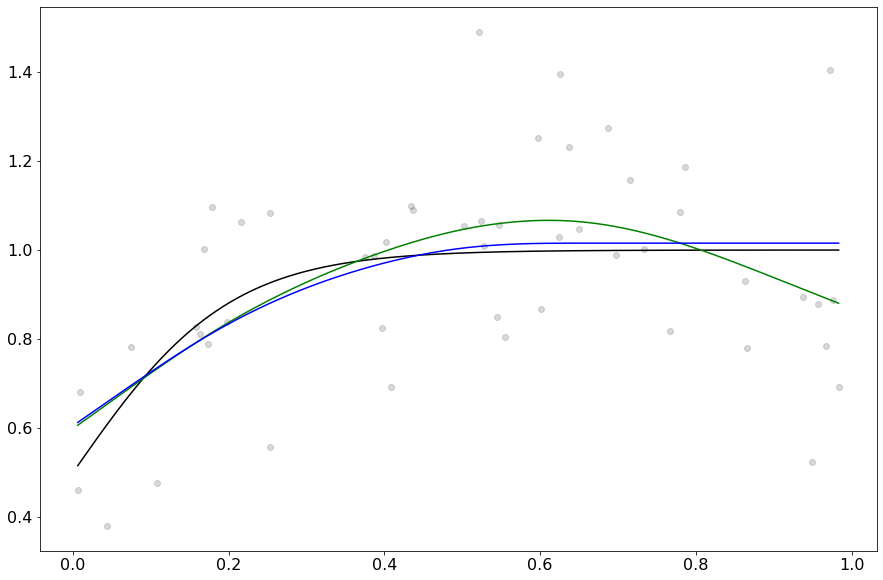

In [19]:
# Simulate the data 
np.random.seed(4)
x = np.sort(np.random.uniform(low=0.0, high=1.0, size=50))
y_teo = simulated_multiple_function(x)
y = y_teo + np.random.normal(0, 0.2, 50)

# Generate thinner covariate sample so the plot looks smoother 
x_ext = np.linspace(np.min(x),np.max(x),1001)
y_ext = simulated_multiple_function(x_ext)

# Get the unconstrained curve 
sin = GridCPsplines(**params3)
_ = sin.fit(x=(x,), y=y)
y_ext_sin = sin.predict(x=(x_ext,))

# Get the non-negative curve
con_nc = GridCPsplines(**params3, int_constraints={0: {0: {"+": 0}}})
_ = con_nc.fit(x=(x,), y=y)
y_ext_con_nc = con_nc.predict(x=(x_ext,))

# Get the non-negative curve
con_nivq = GridCPsplines(**params4, int_constraints={0: {0: {"+": 0}, 1: {"+": 0}, 2: {"-": 0}}})
_ = con_nivq.fit(x=(x,), y=y)
y_ext_con_nivq = con_nivq.predict(x=(x_ext,))

#Plot the most complex results, together with the theoretical curve
fig, ax = plt.subplots(figsize = (15,10))
_ = ax.scatter(x, y, c="k", alpha=0.15)
_ = ax.plot(x_ext, y_ext, c="k", label="Theoretical curve")
_ = ax.plot(x_ext, y_ext_con_nc, c="g", label="Non-negativity over $[x_1, x_n]$")
_ = ax.plot(x_ext, y_ext_con_nivq, c="b",
            label="Non-negativity + Non-decreasing + Concavity over $[x_1, x_n]$ (quartic)")
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = fig.savefig("../img/multiple_papp_20.pdf", bbox_inches="tight")

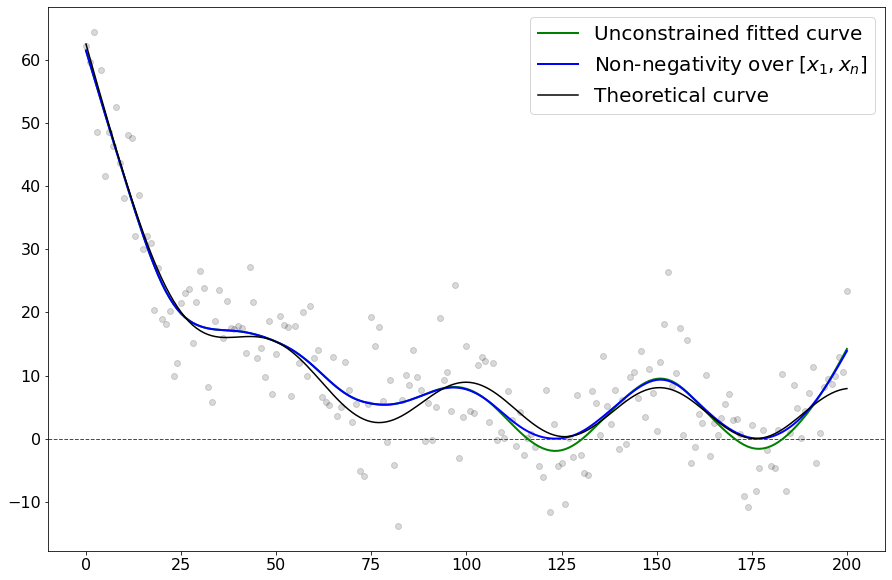

In [20]:
# Simulate the data 
np.random.seed(21)
x = np.linspace(0, 200, 201)
y_teo = simulated_nonneg_function(x)
y = y_teo + np.random.normal(0, 6, 201)

params = {"deg": (3,),
          "ord_d": (2,),
          "n_int": (40,),
          "sp_method": "optimizer",
          "sp_args": {"options": {"ftol": 1e-6}}}

# Get the unconstrained curve 
sin = GridCPsplines(**params)
_ = sin.fit(x=(x,), y=y)

# Get the non-negative curve
con = GridCPsplines(**params, int_constraints={0: {0: {"+": 0.0}}})
_ = con.fit(x=(x,), y=y)

#Plot the results, together with the theoretical curve
fig, ax = plot_curves(
    fittings=(sin, con),
    col_curve=("g", "b"), 
    x=(x, ),
    y=(y, ),
    col_pt=("k",),
    alpha=0.15,
    knot_positions=False,
    constant_constraints=True,
    figsize=(15,10)
)

label_legend = ["Unconstrained fitted curve",
                "Non-negativity over $[x_1,x_n]$",
                "Theoretical curve"]

_ = ax.plot(x, y_teo, c='k', label="Theoretical curve")
_ = ax.legend(
    ax.get_legend_handles_labels()[0],
    label_legend,
    prop={"size": 20},
)
_ = ax.tick_params(axis='both', which='major', labelsize=16)
_ = fig.savefig("../img/nonneg_navarro.pdf", bbox_inches="tight")

_ = pd.DataFrame({"x": x,
                  "y_teo": y_teo,
                  "y": y,
                  "y_sin": sin.y_fitted,
                  "y_con": con.y_fitted}).to_csv("../data/nonneg_example.csv", index=False)

In [21]:
B = con.bspline_bases[0].matrixB
D = PenaltyMatrix(bspline=con.bspline_bases[0]).get_penalty_matrix(**{"ord_d": con.ord_d[0]})
ed = np.trace(np.linalg.solve(B.T @ B + np.multiply(con.best_sp, D.T @ D), B.T @ B))
# Compute the estimated error standard deviation for the unconstrained and the
# non-negative fitted curves
sigma_hat_sin = np.sqrt((np.linalg.norm((y - sin.y_fitted)) ** 2) / (len(y) - ed))
print(f"Estimated standard deviation for the unconstrained model: {sigma_hat_sin.round(2)}")
sigma_hat_con = np.sqrt((np.linalg.norm((y - con.y_fitted)) ** 2) / (len(y) - ed))
print(f"Estimated standard deviation for the non-negative model: {sigma_hat_con.round(2)}")

Estimated standard deviation for the unconstrained model: 6.05
Estimated standard deviation for the non-negative model: 6.13


In [22]:
sin_ls = []
con_ls = []
params = {"deg": (3,),
          "ord_d": (2,),
          "n_int": (40,),
          "sp_method": "optimizer",
          "sp_args": {"options": {"ftol": 1e-6}}}

x = np.linspace(0, 200, 201)
y_teo_sin = sin.y_fitted
y_teo_con = con.y_fitted

if not os.path.exists("../data/confidence_bands_data.csv"):
    # Simulate the data 
    for i in range(1000):
        try:
            np.random.seed(i)
            y_sin = y_teo_sin + np.random.normal(0, sigma_hat_sin, 201)
            y_con = y_teo_con + np.random.normal(0, sigma_hat_con, 201)

            # Get the unconstrained curve 
            sin_ci = GridCPsplines(**params)
            _ = sin_ci.fit(x=(x,), y=y_sin)
            sin_ls.append(sin_ci.y_fitted)

            # Get the non-negative curve
            con_ci = GridCPsplines(**params, int_constraints={0: {0: {"+": 0.0}}})
            _ = con_ci.fit(x=(x,), y=y_con)
            con_ls.append(con_ci.y_fitted)
        except:
            pass

    _ = pd.concat({"unconstrained": pd.DataFrame(sin_ls),
                   "nonnegative": pd.DataFrame(con_ls)}).to_csv("../data/confidence_bands_data.csv")

df_nonneg_ex = pd.read_csv("../data/nonneg_example.csv")
df_cb = pd.read_csv("../data/confidence_bands_data.csv", index_col=[0,1])

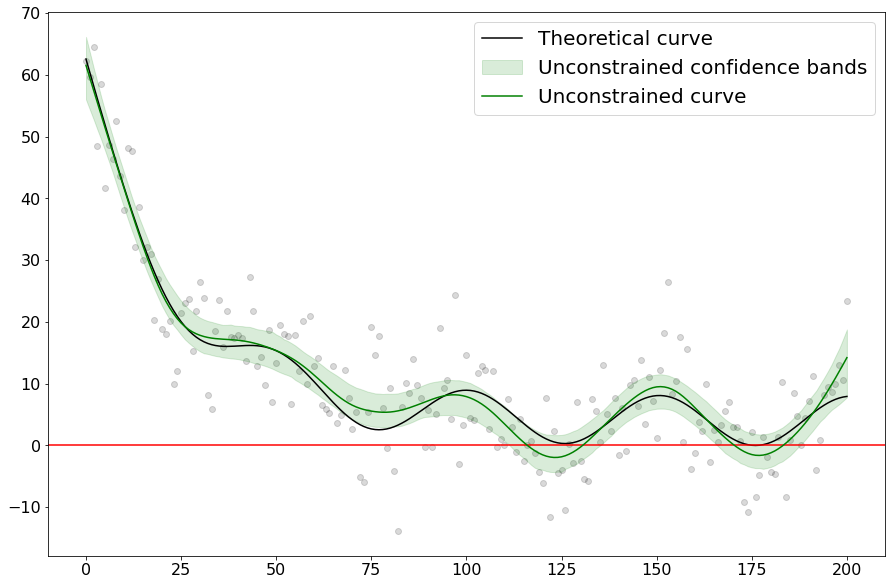

In [23]:
fig, ax = plot_confidence_bands(df=df_cb.loc["unconstrained", :],
                                x=df_nonneg_ex["x"],
                                y=df_nonneg_ex["y"],
                                y_teo=df_nonneg_ex["y_teo"],
                                y_fitted=df_nonneg_ex["y_sin"],
                                constrained=False,
                                color_cb="g",
                                save_path="../img/ci_unconstr.pdf")

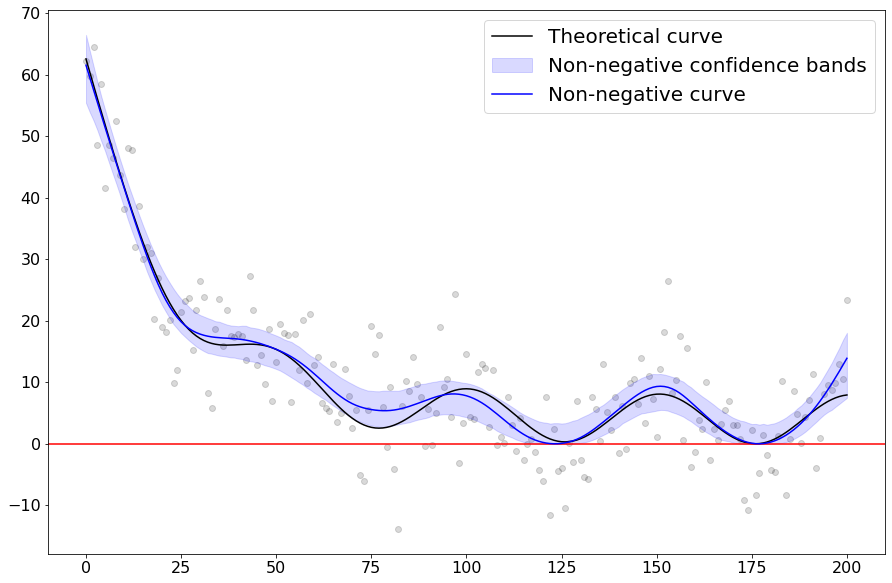

In [24]:
fig, ax = plot_confidence_bands(df=df_cb.loc["nonnegative", :],
                                x=df_nonneg_ex["x"],
                                y=df_nonneg_ex["y"],
                                y_teo=df_nonneg_ex["y_teo"],
                                y_fitted=df_nonneg_ex["y_con"],
                                constrained=True,
                                color_cb="b", 
                                save_path="../img/ci_nonneg.pdf")